# Setting Up
### Import necessary libraries for image processing and to use EfficientNet as the CNN for training.



In [ ]:
# !pip install timm --quiet
import torch
import timm
import torchvision.transforms as T
import torchvision.datasets
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import os, shutil
import zipfile
from pathlib import Path
import random
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using Device: ", device)

Using Device:  cuda


### Setting Up DermNet Dataset

1. **Download the Dataset using `kagglehub`**  
   - Retrieves the DermNet skin disease classification dataset from Kaggle.
   - Stores it under a temporary working directory (`/kaggle/input/dermnet/train`).

2. **Define Source and Target Paths**  
   - `source_dir`: the path to the downloaded training images.
   - `target_train` / `target_val`: local directories to organize training and validation data.

3. **Auto-Detect Illness Classes**  
   - Scans subdirectories in `source_dir` to extract class names.
   - Supports flexible class inclusion without hardcoding.

4. **Split and Copy Images**  
   - For each class:
     - Shuffles the image list.
     - Splits it into **80% training** and **20% validation**.
     - Copies up to 100% of each subset into the respective target folders.
   - Each class gets its own subfolder in both `dataset/train` and `dataset/val`.

> The old `dataset/` directory (if present) is removed to ensure no errors when importing.

> After this step, your dataset is structured and ready for loading with `ImageFolder`.


In [ ]:
# !pip install kagglehub --quiet
from pathlib import Path
import os
import kagglehub

# Download the dataset and move to the training folder
path = kagglehub.dataset_download("shubhamgoel27/dermnet")

source_dir = Path("/kaggle/input/dermnet/train")
target_train = Path("dataset/train")
target_val = Path("dataset/val")

print(f"Source directory: {source_dir}")
print(f"Target training directory: {target_train}")
print(f"Target validation directory: {target_val}")


illness_classes = [f.name for f in source_dir.iterdir() if f.is_dir()]


!rm -rf dataset
# Create new folders for classification and copy images (up to 200 per class)
for cls in illness_classes:
  os.makedirs(target_train / cls, exist_ok=True)
  os.makedirs(target_val / cls, exist_ok=True)

  img_list = list((source_dir / cls).glob("*.jpg"))
  random.shuffle(img_list)

  split_idx = int(0.8 * len(img_list))
  train_imgs = img_list[:split_idx]
  val_imgs = img_list[split_idx:]

  for img in train_imgs:
    shutil.copy(img, target_train / cls)
  for img in val_imgs:
    shutil.copy(img, target_val / cls)

print("Dataset ready. Classes: ", illness_classes)

Source directory: /kaggle/input/dermnet/train
Target training directory: dataset/train
Target validation directory: dataset/val
Dataset ready. Classes:  ['Light Diseases and Disorders of Pigmentation', 'Lupus and other Connective Tissue diseases', 'Acne and Rosacea Photos', 'Systemic Disease', 'Poison Ivy Photos and other Contact Dermatitis', 'Vascular Tumors', 'Urticaria Hives', 'Atopic Dermatitis Photos', 'Bullous Disease Photos', 'Hair Loss Photos Alopecia and other Hair Diseases', 'Tinea Ringworm Candidiasis and other Fungal Infections', 'Psoriasis pictures Lichen Planus and related diseases', 'Melanoma Skin Cancer Nevi and Moles', 'Nail Fungus and other Nail Disease', 'Scabies Lyme Disease and other Infestations and Bites', 'Eczema Photos', 'Exanthems and Drug Eruptions', 'Herpes HPV and other STDs Photos', 'Seborrheic Keratoses and other Benign Tumors', 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 'Vasculitis Photos', 'Cellulitis Impetigo and other Bacter

### Data Augmentation, Normalization & EfficientNet-B3 Model Setup

1. **Define Data Transformations**  
   - **Validation Transform (`transform`)**:
     - Resizes all images to `224x224` (EfficientNet input size).
     - Converts images to PyTorch tensors.
     - Normalizes with ImageNet mean and standard deviation.
   - **Training Transform (`transform_train`)**:
     - Adds augmentation for better generalization:
       - `RandomHorizontalFlip`: flips images horizontally.
       - `RandomRotation(15)`: rotates images up to ±15°.
       - `ColorJitter`: randomly adjusts brightness, contrast, and saturation.
     - Applies the same resize, tensor conversion, and normalization as validation.

2. **Load Datasets with Transforms**
   - Uses `ImageFolder` to load training and validation sets from organized directory structure.
   - Applies the respective transform pipelines.
   - Initializes DataLoaders (`train_dl`, `val_dl`) with `batch_size=32`.

3. **Inspect Class Information**
   - Extracts class names and prints the number of classes detected.

4. **Load EfficientNet-B3 Model**
   - Loads a pretrained `EfficientNet-B3` model using the `timm` library.
   - Adjusts the classifier head to match the number of detected classes.
   - Adds a Dropout layer (p=0.4) to reduce overfitting.

5. **Transfer Learning Setup (Optional)**
   - (Commented Out) Option to **freeze all layers** for feature extraction.
   - (Commented Out) Option to **selectively unfreeze deeper layers**, such as:
     - Blocks 4, 5, 6
     - `conv_head`, `bn2`, and `classifier` layers
   - Allows for fine-tuning only a portion of the network for better generalization on the new dataset.

In [ ]:
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

transform_train = T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(15),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

train_dataset = ImageFolder("dataset/train", transform=transform_train)
val_dataset = ImageFolder("dataset/val", transform=transform)
train_dl = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=32)

class_names = train_dataset.classes
print("Found classes:", class_names)
print("Number of classes:", len(class_names))

# Try running the model
model = timm.create_model("efficientnet_b3", pretrained=True, num_classes=len(class_names)).to(device)

# Add dropout
in_features = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Dropout(p=0.4),
    nn.Linear(in_features, len(class_names))
)


# # Freeze all layers
# for param in model.parameters():
#     param.requires_grad = False

# # Unfreeze some layers
# for name, param in model.named_parameters():
#     if "blocks.4" in name or "blocks.5" in name or "blocks.6" in name or "conv_head" in name or "bn2" in name or "classifier" in name:
#         param.requires_grad = True

Found classes: ['Acne and Rosacea Photos', 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 'Atopic Dermatitis Photos', 'Bullous Disease Photos', 'Cellulitis Impetigo and other Bacterial Infections', 'Eczema Photos', 'Exanthems and Drug Eruptions', 'Hair Loss Photos Alopecia and other Hair Diseases', 'Herpes HPV and other STDs Photos', 'Light Diseases and Disorders of Pigmentation', 'Lupus and other Connective Tissue diseases', 'Melanoma Skin Cancer Nevi and Moles', 'Nail Fungus and other Nail Disease', 'Poison Ivy Photos and other Contact Dermatitis', 'Psoriasis pictures Lichen Planus and related diseases', 'Scabies Lyme Disease and other Infestations and Bites', 'Seborrheic Keratoses and other Benign Tumors', 'Systemic Disease', 'Tinea Ringworm Candidiasis and other Fungal Infections', 'Urticaria Hives', 'Vascular Tumors', 'Vasculitis Photos', 'Warts Molluscum and other Viral Infections']
Number of classes: 23


model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

In [ ]:
# Debugging stuff, don't run unless necessary
from collections import Counter
labels = [y for _, y in train_dataset.samples]
Counter(labels)


Counter({0: 672,
         1: 919,
         2: 391,
         3: 358,
         4: 230,
         5: 988,
         6: 323,
         7: 191,
         8: 324,
         9: 454,
         10: 336,
         11: 370,
         12: 832,
         13: 208,
         14: 1124,
         15: 344,
         16: 1096,
         17: 484,
         18: 1040,
         19: 169,
         20: 385,
         21: 332,
         22: 868})

# Training Loop
### Using Class Balancing, Optimizer, Scheduler & Early Stopping

1. **Class Weights (Imbalanced Data Handling)**  
   - Calculates balanced class weights using `sklearn` to handle class imbalance.
   - Applies the weights to the `CrossEntropyLoss` function to give underrepresented classes more influence.

2. **Loss Function and Optimizer**
   - Uses `CrossEntropyLoss` with or without class weights.
   - Uses `AdamW` optimizer with weight decay (`1e-5`) for better regularization.
   - Filters are not used since all layers are trainable (no freezing).

3. **Learning Rate Scheduler**
   - `ReduceLROnPlateau`: Monitors validation loss and reduces learning rate if it stagnates.
   - Reduces LR by a factor of 0.5 after 2 non-improving epochs.

4. **Early Stopping Mechanism**
   - Monitors validation loss to determine if the model is improving.
   - If validation loss doesn't improve for `4` consecutive epochs, training is stopped early.
   - Saves the best-performing model to `"best_model.pth"`.

5. **Training Loop (`num_epochs = 20`)**
   - Sets model to training mode.
   - For each batch:
     - Moves data to device.
     - Runs forward pass and computes loss.
     - Performs backpropagation and optimizer step.
     - Tracks total training loss per epoch.

6. **Validation Phase**
   - Runs model in evaluation mode with no gradients.
   - Calculates validation loss and accuracy.
   - Feeds validation loss to the scheduler.

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(class_names)),
    y=[s[1] for s in train_dataset.samples]
)

class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

model = model.to(device)
# with weighted classes
loss_fn = nn.CrossEntropyLoss(weight=class_weights)
# with no weights
loss_fn = nn.CrossEntropyLoss()

# Comment this optimizer out since we are not freezing any layers
# optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

# Learning rate scheduler patch
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)


# Early stopping setup
best_loss = float('inf')
patience = 4
epochs_no_improve = 0
num_epochs = 20  # or however many you want

# Training loop
for epoch in range(num_epochs):
  model.train()
  total_loss = 0
  for xb, yb in train_dl:
    xb, yb = xb.to(device), yb.to(device)
    pred = model(xb)
    loss = loss_fn(pred, yb)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    total_loss += loss.item()

  avg_loss = total_loss / len(train_dataset)
  print(f"Epoch {epoch+1}, Average loss: {avg_loss:.4f}")


  # Validation Test Loop
  model.eval()
  val_loss = 0
  correct = 0
  total = 0
  with torch.no_grad():
    for xb, yb in val_dl:
      xb, yb = xb.to(device), yb.to(device)
      out = model(xb)
      loss = loss_fn(out, yb)
      val_loss += loss.item()

      pred = torch.argmax(out, dim=1)
      correct += (pred == yb).sum().item()
      total += yb.size(0)

  avg_val_loss = val_loss / len(val_dl)
  val_acc = 100 * correct / total
  print(f"Validation Loss: {avg_val_loss:.4f}")
  print(f"Validation Accuracy: {val_acc:.2f}%")

  # Early stopping logic
  if avg_val_loss < best_loss:
    best_loss = avg_val_loss
    epochs_no_improve = 0
    torch.save(model.state_dict(), "best_model.pth")
    print("Model improved - saved.")
  else:
    epochs_no_improve += 1
    print(f"No improvement for {epochs_no_improve} epoch(s).")
    if epochs_no_improve == patience:
      print("Early stopping triggered.")
      break
  scheduler.step(val_loss)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1, Average loss: 0.0805
Validation Loss: 2.2005
Validation Accuracy: 35.75%
Model improved - saved.
Epoch 2, Average loss: 0.0614
Validation Loss: 1.8473
Validation Accuracy: 45.40%
Model improved - saved.
Epoch 3, Average loss: 0.0484
Validation Loss: 1.6660
Validation Accuracy: 51.27%
Model improved - saved.
Epoch 4, Average loss: 0.0369
Validation Loss: 1.5537
Validation Accuracy: 54.95%
Model improved - saved.
Epoch 5, Average loss: 0.0272
Validation Loss: 1.5488
Validation Accuracy: 56.08%
Model improved - saved.
Epoch 6, Average loss: 0.0197
Validation Loss: 1.5421
Validation Accuracy: 57.97%
Model improved - saved.
Epoch 7, Average loss: 0.0138
Validation Loss: 1.6049
Validation Accuracy: 58.29%
No improvement for 1 epoch(s).
Epoch 8, Average loss: 0.0102
Validation Loss: 1.6514
Validation Accuracy: 59.25%
No improvement for 2 epoch(s).
Epoch 9, Average loss: 0.0076
Validation Loss: 1.6866
Validation Accuracy: 59.09%
No improvement for 3 epoch(s).
Epoch 10, Average loss: 0

Check confusion matrix, only for debugging purposes, no need to run.

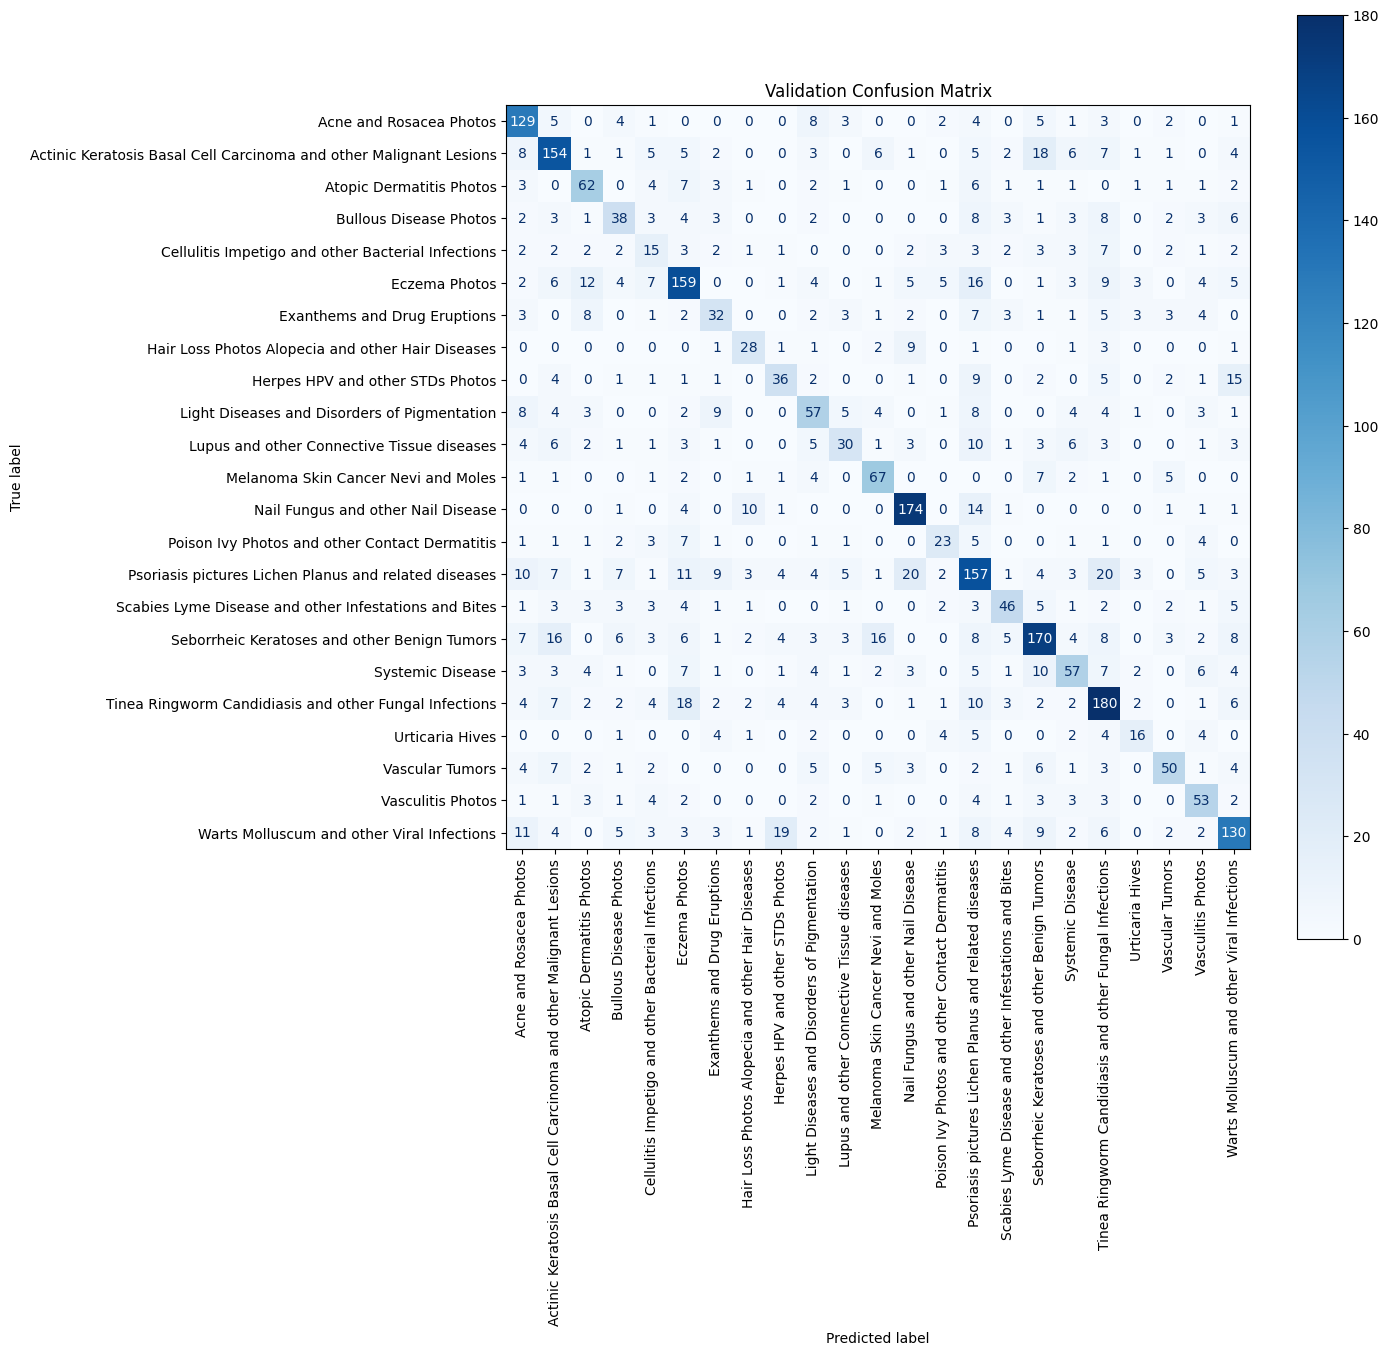

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Set model to evaluation mode
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for xb, yb in val_dl:
        xb, yb = xb.to(device), yb.to(device)
        out = model(xb)
        preds = torch.argmax(out, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(yb.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Optionally normalize
# cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(12, 12))
disp.plot(ax=ax, xticks_rotation=90, cmap='Blues')
plt.title("Validation Confusion Matrix")
plt.show()


In [ ]:
import torch
import json

# Save class names
with open("class_names.json", "w") as f:
    json.dump(class_names, f)

### Evaluation by Meta-Categories (Generalization Check)

1. **Define Meta-Category Mapping**
   - A dictionary `category_map` groups fine-grained disease labels into broader categories (e.g., "Psoriasis" and "Eczema" → "Inflammatory").
   - Helps evaluate model generalization beyond specific classes.

2. **Set Up Evaluation Tools**
   - Builds a reverse mapping `idx_to_class` to convert model predictions from index to class names.
   - Uses a `defaultdict` (`meta_confusion`) to track confusion matrix at the meta-category level.

3. **Run Model Inference on Validation Set**
   - For each batch in `val_dl`, predicts class labels using `argmax`.
   - Maps both predicted and true class labels to their corresponding meta-categories using `category_map`.
   - Increments correct predictions if predicted meta matches true meta.
   - Records meta-to-meta confusion in a nested dictionary for deeper analysis.

4. **Compute Meta-Category Accuracy**
   - Accuracy is calculated as the percentage of samples where the predicted meta-category matched the true meta-category.
   - Useful for measuring broader diagnostic capability even when specific class labels are confused.


In [ ]:
# Mapping fine-grained classes to broader categories
category_map = {
    'Acne and Rosacea Photos': 'Inflammatory',
    'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions': 'Cancerous',
    'Atopic Dermatitis Photos': 'Inflammatory',
    'Bullous Disease Photos': 'Autoimmune',
    'Cellulitis Impetigo and other Bacterial Infections': 'Infectious',
    'Eczema Photos': 'Inflammatory',
    'Exanthems and Drug Eruptions': 'Drug Reaction',
    'Hair Loss Photos Alopecia and other Hair Diseases': 'Hair Disorders',
    'Herpes HPV and other STDs Photos': 'Infectious',
    'Light Diseases and Disorders of Pigmentation': 'Pigmentation',
    'Lupus and other Connective Tissue diseases': 'Autoimmune',
    'Melanoma Skin Cancer Nevi and Moles': 'Cancerous',
    'Nail Fungus and other Nail Disease': 'Fungal',
    'Poison Ivy Photos and other Contact Dermatitis': 'Inflammatory',
    'Psoriasis pictures Lichen Planus and related diseases': 'Inflammatory',
    'Scabies Lyme Disease and other Infestations and Bites': 'Infectious',
    'Seborrheic Keratoses and other Benign Tumors': 'Benign',
    'Systemic Disease': 'Other',
    'Tinea Ringworm Candidiasis and other Fungal Infections': 'Fungal',
    'Urticaria Hives': 'Allergic',
    'Vascular Tumors': 'Benign',
    'Vasculitis Photos': 'Autoimmune',
    'Warts Molluscum and other Viral Infections': 'Infectious'
}

from collections import defaultdict

# Reverse lookup: class index to name
idx_to_class = {v: k for k, v in train_dataset.class_to_idx.items()}

# Track meta-category accuracy
correct_meta = 0
total_meta = 0
meta_confusion = defaultdict(lambda: defaultdict(int))

model.eval()
with torch.no_grad():
    for xb, yb in val_dl:
        xb, yb = xb.to(device), yb.to(device)
        out = model(xb)
        preds = torch.argmax(out, dim=1)

        for true_idx, pred_idx in zip(yb, preds):
            true_class = idx_to_class[true_idx.item()]
            pred_class = idx_to_class[pred_idx.item()]

            true_meta = category_map[true_class]
            pred_meta = category_map[pred_class]

            meta_confusion[true_meta][pred_meta] += 1

            if true_meta == pred_meta:
                correct_meta += 1
            total_meta += 1

meta_acc = 100 * correct_meta / total_meta
print(f"\nMeta-category Accuracy: {meta_acc:.2f}%")



Meta-category Accuracy: 64.19%


# Prediction Block

1. **Load and Display the Image**  
   - Opens the image from a specified path and converts it to RGB format (ensures compatibility).
   - Displays the image using `matplotlib` for visual confirmation.

2. **Preprocess the Image**  
   - Applies the same transformation pipeline used during training (`Resize + ToTensor`).
   - Adds a batch dimension with `.unsqueeze(0)` and moves the tensor to the correct device.

3. **Run Inference with Trained Model**  
   - Sets the model to evaluation mode (`model.eval()`).
   - Performs a forward pass under `torch.no_grad()` to avoid gradient computation.
   - Applies `softmax` to obtain class probabilities.

4. **Interpret the Prediction**  
   - Uses `torch.max` to get the predicted class and its confidence score.
   - If confidence is **greater than 0.85**, displays the predicted class and confidence.
   - If confidence is **low**, displays a message indicating a possible skin irregularity.

In [ ]:
!ls -lh best_model.pth


-rw-r--r-- 1 root root 27M Jul 23 02:18 best_model.pth


In [ ]:
import timm
import torch
import torch.nn as nn
from torchvision import transforms as T
import json

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load class names
with open("class_names.json", "r") as f:
    class_names = json.load(f)

# Load the previous transform
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Load best model
model = timm.create_model("efficientnet_b3", pretrained=False)
in_features = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Dropout(p=0.4),
    nn.Linear(in_features, len(class_names))
)
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model = model.to(device)
model.eval()

EfficientNet(
  (conv_stem): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
        (bn1): BatchNormAct2d(
          40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(40, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (b

Saving test3.jpg to test3 (1).jpg


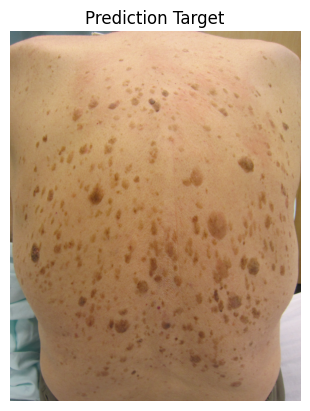

Prediction: Melanoma Skin Cancer Nevi and Moles (confidence: 0.63)


In [ ]:
from PIL import Image
from google.colab import files
import torch
import matplotlib.pyplot as plt

uploaded = files.upload()

img_path = next(iter(uploaded))

img = Image.open(img_path).convert("RGB")


plt.imshow(img)
plt.axis('off')
plt.title("Prediction Target")
plt.show()

img_tensor = transform(img).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
  output = model(img_tensor)
  probs = torch.softmax(output, dim=1)
  conf, pred = torch.max(probs, dim=1)

  if conf.item() > 0.60:
    print(f"Prediction: {class_names[pred.item()]} (confidence: {conf.item():.2f}%)")
  else:
    print("Low confidence - possible skin irregularity detected.")